<a href="https://colab.research.google.com/github/apadhikary/ERA_V2_New/blob/main/S13/Session%2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Models and Modules

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/apadhikary/ERA_V2_New.git -q --quiet
# !mv ERA_V2/pytorch-era2-main/* .
# !rm -rf ERA_V2/pytorch-era2-main
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam
# !pip install pytorch-lightning-bolts
!pip install lightning-bolts

# For inline matplotlib plotting
%matplotlib inline

fatal: destination path 'ERA_V2_New' already exists and is not an empty directory.
Loaded Modules and Models
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Data Transformation

In [3]:
import albumentations as A
from albumentations import Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, ShiftScaleRotate, CoarseDropout
from albumentations.pytorch.transforms import ToTensorV2
train_transforms = A.Compose([
          PadIfNeeded(40),
          RandomCrop(32,32),
          HorizontalFlip(),
          CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914*255, 0.4822*255, 0.4471*255], mask_fill_value=None, always_apply=False, p=0.3),
          Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
          ToTensorV2()
        ])

test_transforms = A.Compose([
            Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
            ToTensorV2()
        ])

val_transforms = A.Compose([
            Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
            ToTensorV2()
        ])

In [13]:
import albumentations as A
from albumentations import Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, ShiftScaleRotate, CoarseDropout
class album_Compose_train():
    def __init__(self):
        self.albumentations_transform = A.Compose([
                            RandomCrop (height = 32, width = 32, always_apply=False, p=4.0),
                            HorizontalFlip(),
                            #Cutout(num_holes=1, max_h_size=8, max_w_size=8, always_apply=True),
                            CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914*255, 0.4822*255, 0.4471*255], mask_fill_value=None),
                            Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
                            ToTensorV2()])
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

class album_Compose_test():
    def __init__(self):
        self.albumentations_transform = A.Compose([#  transforms.Resize((28, 28)),
                           #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                           Normalize(mean=[0.4914, 0.4822, 0.4471],std=[0.2469, 0.2433, 0.2615]),
                           ToTensorV2()
                           ])

    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

In [39]:
import torchvision
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

val_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

### Loading train and test data with transforms and loader functions

In [40]:
from pl_bolts.datamodules import CIFAR10DataModule
import os
import torch

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=val_transforms,
)

In [41]:
!pip install pytorch_lightning

In [42]:
import torch.nn.functional as F
import torch.nn as nn
from pytorch_lightning import LightningModule
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy
import torch

dropout_value = 0.1

class X(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(X, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1, padding=1,bias = False),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv1(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1, padding=1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.conv(out)
        out = out + x
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Prep Layer
        self.preplayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) ## 32x32

        # Layer 1
        self.X1 = X(in_channels=64,out_channels=128) # 16x16
        self.R1 = ResBlock(in_channels=128,out_channels=128) # 32x32

        # Layer 2
        self.X2 = X(in_channels=128,out_channels=256)

        # Layer 3
        self.X3 = X(in_channels=256,out_channels=512)
        self.R3 = ResBlock(in_channels=512,out_channels=512)

        # Max Pool
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)

        # FC
        self.fc = nn.Linear(512,10)

    def forward(self, x):
        batch_size = x.shape[0]

        out = self.preplayer(x)

        # Layer 1
        X = self.X1(out) ## 16x16
        R1 = self.R1(X)


        out = X + R1

        # Layer 2
        out = self.X2(out)

        # Layer 3
        X = self.X3(out)
        R2 = self.R3(X)

        out = X + R2

        out = self.maxpool(out)

        # FC
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        # return F.log_softmax(out, dim=-1)
        return out.view(-1, 10)

class LitCustomResnet(LightningModule):
    def __init__(self, lr = 0.05,batch_size=64):
        super().__init__()
        self.model = Net()
        self.save_hyperparameters()
        self.BATCH_SIZE=batch_size

    def forward(self,x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self,batch,batch_id):
        x,y = batch
        logits = self(x)
        loss = F.cross_entropy(logits,y)
        self.log("training loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x,y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        # print(preds.shape,y.shape)
        acc= accuracy(preds,y, task = "multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            # momentum=0.9,
            # weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // self.BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.003,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [43]:
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
# from ERA_V2_New.models.custom_resnet import *

model = LitCustomResnet(lr=0.01, batch_size = BATCH_SIZE)

trainer = Trainer(
    max_epochs=24,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Net  | 4.1 M 
-------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.260    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
: AssertionErrorcan only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f705a994280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9072999954223633     │
│         test_loss         │    0.29351577162742615    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.29351577162742615, 'test_acc': 0.9072999954223633}]

,lr-Adam,training loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.000163,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.415861,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.262727,0.5507,NaN,NaN
NaN,0.000294,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.130382,NaN,NaN,NaN,NaN


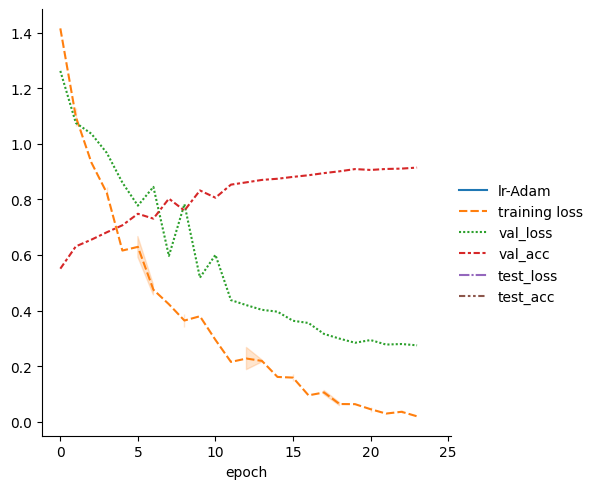

In [44]:
import pandas as pd
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [45]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import torch
from albumentations import Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, ShiftScaleRotate, CoarseDropout
from albumentations.pytorch.transforms import ToTensorV2

from pytorch_grad_cam.base_cam import BaseCAM

import torchvision
from torchvision import datasets

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pl_bolts.datamodules import CIFAR10DataModule

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix


import os
from tqdm import tqdm

def unnormalize(img):
    channel_means = (0.4914, 0.4822, 0.4471)
    channel_stdevs = (0.2469, 0.2433, 0.2615)
    img = img.numpy().astype(dtype=np.float32)

    for i in range(img.shape[0]):
        img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
    return np.transpose(img, (1,2,0))

def plot_grad_cam_images_custom_resnet(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.R3]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(unnormalize(misclassified_images[i].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

        # npimg = unnormalize(misclassified_images[i].cpu())
        # plt.imshow(npimg, cmap='gray', interpolation='none')

        # npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot GradCAM Misclassified Images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


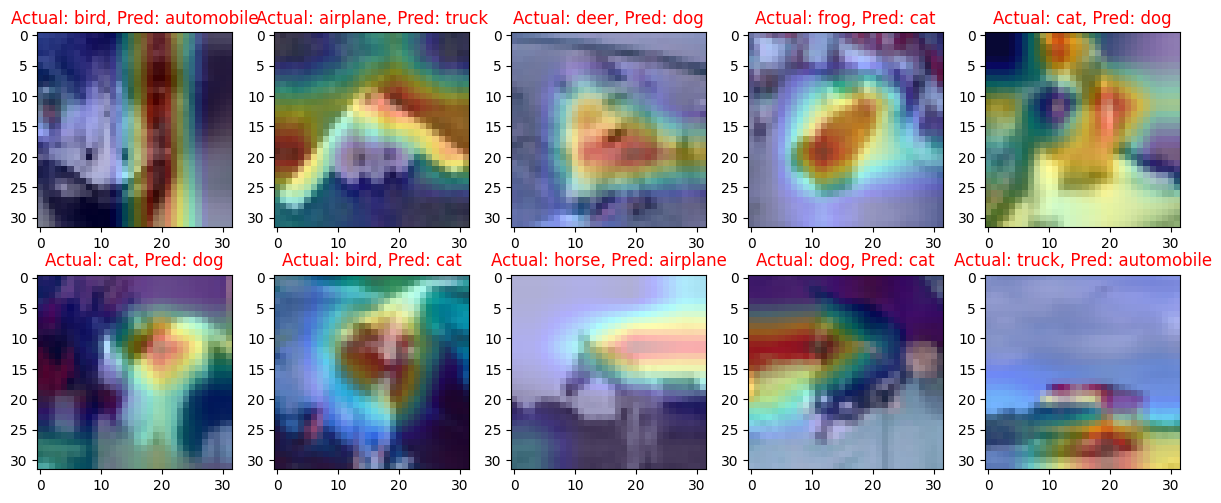

In [46]:
import torch
# from ERA_V2_New.S13.utils import plot_grad_cam_images_custom_resnet
plot_grad_cam_images_custom_resnet(model.model, cifar10_dm.test_dataloader(), cifar10_dm.dataset_train.dataset.classes, device=torch.device("cpu"))

### Save the Model

In [ ]:
torch.save(model.model.state_dict(), "custom_resnet_model.pt")

### Saving Misclassified Images

In [ ]:
!mkdir misclassfied_images
from PIL import Image
import numpy as np

test_loader = cifar10_dm.test_dataloader()
classes =  cifar10_dm.dataset_train.dataset.classes
device = torch.device("cuda")
model1 = model.model.to(device)

# set model to evaluation mode
model1.eval()

misclassified_images = []

fig_idx = 1
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model1(data)
        _, pred = torch.max(output, 1)
        for i in range(len(pred)):
            if pred[i] != target[i]:
                misclassified_images.append(data[i])
                npimg = unnormalize(data[i].cpu())
                im = Image.fromarray((npimg*255).astype(np.uint8))
                im.save(f"./misclassfied_images/Target_{classes[target[i]]}_Pred_{classes[pred[i]]}_{fig_idx}.jpeg")
                if fig_idx > 25:
                    break
                fig_idx+=1


import shutil

shutil.make_archive("./misclassfied_images", 'zip', "./misclassfied_images")